In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
scaler = MinMaxScaler(feature_range=(-1, 1))

pf = pd.read_csv('data/Google_Stock_Price_Train.csv')
pf_test = pd.read_csv('data/Google_Stock_Price_Test.csv')

pf_test['Volume'] = pf_test['Volume'].str.replace(',','').astype(float)

pf['Volume'] = pf['Volume'].str.replace(',','').astype(float)
pf['Close'] = pf['Close'].str.replace(',','').astype(float)

In [2]:
head_names = list(pf.columns.values)[1:]
head_names_original = head_names.copy()

In [3]:
def split_data(volume, sequence_size, M):
    data = []
    for index in range(len(volume.to_numpy())-sequence_size): 
        data.append(volume.to_numpy()[index: index+sequence_size])
    data = np.array(data)
    
    vali_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (vali_set_size)
    m = -1-M
    
    x_train = data[:train_set_size ,: -1 ,:]
    y_train = data[:train_set_size ,m:-1,:]
    x_vali = data[train_set_size :,: -1]
    y_vali = data[train_set_size:, m:-1,:]
    
    
    y_train_holder = []
    for i in range(len(y_train)):
        k = []
        for n in range(M):
            k.append(y_train[i][n][:])
        y_train_holder.append(k)
        
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    
    y_vali, y_train = np.array(y_vali_holder), np.array(y_train_holder)
    return [x_train, y_train, x_vali, y_vali]

In [4]:
def test_data(volume, sequence_size, M):
    data = []
    for index in range(len(volume.to_numpy())-sequence_size): 
        data.append(volume.to_numpy()[index: index+sequence_size])
    data = np.array(data)
    m = -1-M
    x_vali = data[:,: -1]
    y_vali = data[:, m:-1,:]
    y_vali_holder = []
    for i in range(len(y_vali)):
        k = []
        for n in range(M):
            k.append(y_vali[i][n][:])
        y_vali_holder.append(k)
    y_vali= np.array(y_vali_holder)
    return [x_vali, y_vali]

In [5]:
pf_test_head_names = list(pf_test.columns.values)[1:]
pf_test_head_names_original = head_names.copy()
pf_test = pf_test[pf_test_head_names_original]
for i in pf_test_head_names_original:
    pf_test[i] = scaler.fit_transform(pf_test[i].values.reshape(-1,1))
# pf_test

In [6]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, input_sequence,M):
#         print('x.shape',x.shape)
        h = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
#         print('h0.shape',h0.shape)
        c = torch.zeros(self.num_layers, input_sequence.size(0), self.hidden_dim).requires_grad_()
#         print('c0.shape',c0.shape)
        out, (hh, cc) = self.lstm(input_sequence, (h.detach(), c.detach()))
#         print('out.shape',out.shape)
        out = self.fc(out[:, -1, :]) 
        out = out.reshape(-1,M,5)
#         print('self.fc(out[:, -1, :]).shape',out.shape)
        return out

In [7]:
def calculate(volume, N, M, num_epochs, num_layers, col_name, x_train, x_vali, y_train_lstm, y_vali_lstm):
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train_lstm).float()
    y_vali_lstm = torch.tensor(y_vali_lstm).float()
    
    input_size = volume.shape[1]
    hidden_layer_size = N * input_size
    output_size = M*5
    
    model = LSTM(input_dim=input_size, hidden_dim=hidden_layer_size, output_dim=output_size, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
    
    hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    y_train_pred = []
    loss = 0
    for t in range(num_epochs):
        y_train_pred = model(x_train,M)
#         print('y_train_pred',y_train_pred)
#         print('y_train_lstm',y_train_lstm)
#         print('y_train_pred.shape',y_train_pred.shape)
#         print('y_train_lstm.shape',y_train_lstm.shape)
        loss = criterion(y_train_pred, y_train_lstm)
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    print("Epoch ", num_epochs, "MSE: ", loss.item())
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    
    y_train_lstm_plot = y_train_lstm.tolist()
    y_train_pred_plot = y_train_pred.tolist()
    
    pred_vali = model(x_vali,M)
    pred_vali_plot = pred_vali.tolist()
    y_vali_lstm_plot = y_vali_lstm.tolist()
    loss_rate = hist
    return y_train_lstm_plot, y_train_pred_plot, pred_vali_plot, y_vali_lstm_plot,loss_rate, model
    


In [8]:
# def test_plots_and_calculation(pf_test, N, M, model, epochs_list):
#     x_test, y_test = test_data(pf_test, N, M)
#     y_test = torch.tensor(y_test).float()
#     x_test = torch.tensor(x_test).float()

    
    
    
    
#     y_test_pred = model(x_test,M)
#     y_test_pred = y_test_pred.tolist()
#     y_test_plot = y_test.copy().tolist()
# #     y_test_pred = torch.tensor(y_test_pred).float()
# #     y_test_plot = torch.tensor(y_test_plot).float()
    
    
#     pred_vali = model(x_test,M)
#     pred_vali_plot = pred_vali.tolist()
# #     y_vali_lstm_plot = y_vali_lstm.tolist()
# #     loss_rate = hist
    
    
    
    
#     x = []
#     for i in range(len(pf_test)):
#         x.append(i)
#     fig = plt.figure(figsize=(10, 30))
#     counter = 0
#     for h in range(len(head_names)):
#         for t in range(len(pred_vali_plot[h])):
#             temp = 0
#             for q in range(M):
#                 temp += (1/M)*pred_vali_plot[h][t][q][h]
#             pred_vali_plot[h][t] = temp
#         for t in range(len(y_test_plot[h])):
#             temp = 0
#             for q in range(M):
#                 temp += (1/M)*y_test_plot[h][t][q][h]
#             y_test_plot[h][t] = temp
    
    
    
    
    
#     counter = 0
#     print('------------testing plots----------')
#     for i in range(len(head_names)):
#         counter+=1
#         ax = plt.subplot(len(head_names)*2, 2, counter)
#         title = 'Testing: epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
#         ax.set_title(title)
#         plt.plot(x,y_test_plot[i], label = head_names[i]+' original')
#         plt.plot(x,pred_vali_plot[i], label = head_names[i]+' predict')
#         x_learning_curve = []
#         plt.legend()
#         plt.tight_layout()
#     plt.legend()
    
    
    
    
    
# test_plots_and_calculation(pf_test, N, M, model, epochs_list)
    
    

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  10 MSE:  0.2231285721063614
Training time: 0.03659701347351074
Epoch  10 MSE:  0.2547629475593567
Training time: 0.026306867599487305
Epoch  10 MSE:  0.1985357254743576
Training time: 0.029006242752075195
Epoch  10 MSE:  0.2359394133090973
Training time: 0.02606487274169922
Epoch  10 MSE:  0.2596002221107483
Training time: 0.02460503578186035
------------Validation plots----------


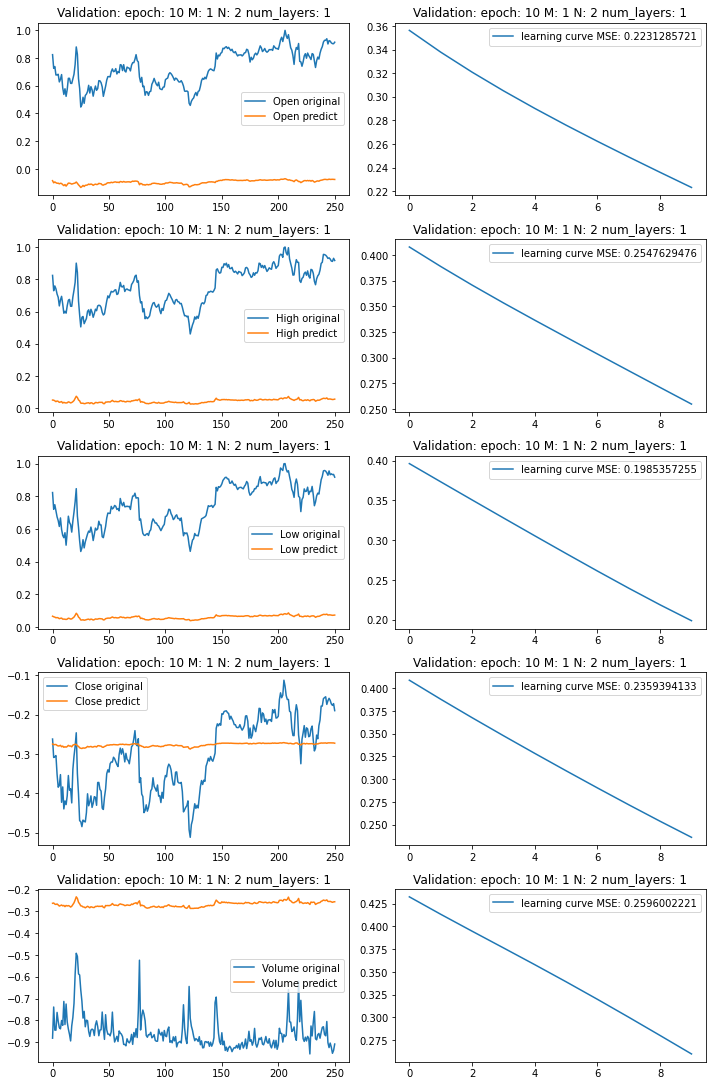

In [9]:
def hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list):
    num_epochs = epochs_list
    y_train_lstm_list, y_train_pred_list, pred_vali_plot_list, y_vali_lstm_plot_list, loss_rate_list = [], [], [], [], []
    for i in head_names:
        pf[i] = scaler.fit_transform(pf[i].values.reshape(-1,1))
    volume = pf[head_names_original]
    x_train, y_train, x_vali, y_vali = split_data(volume, N, M)
    x_train = torch.tensor(x_train).float()
    x_vali = torch.tensor(x_vali).float()
    y_train_lstm = torch.tensor(y_train).float()
    y_vali_lstm = torch.tensor(y_vali).float()
    i ='k'
    for i in head_names:
        y_train_lstm, y_train_pred, pred_vali_plot, y_vali_lstm_plot, loss_rate, model = calculate(volume, N, 
        M, num_epochs, num_layers, i, x_train, x_vali, y_train_lstm, y_vali_lstm)
#     print('y_train_lstm',y_train_lstm)
#     for i in head_names:
        y_train_lstm_list.append(y_train_lstm)
        y_train_pred_list.append(y_train_pred)
        loss_rate_list.append(loss_rate)
        pred_vali_plot_list.append(pred_vali_plot) 
        y_vali_lstm_plot_list.append(y_vali_lstm_plot)
    x = []

    for i in range(len(y_vali_lstm_plot_list[0])):
        x.append(i)
    fig = plt.figure(figsize=(10, 30))
    counter = 0
    for h in range(len(head_names)):
        for t in range(len(y_vali_lstm_plot_list[h])):
            temp = 0
            for q in range(M):
#                 print('h',h,'t',t)
#                 print('y_vali_lstm_plot_list[1][0]1',y_vali_lstm_plot_list[1][0])
                temp += (1/M)*y_vali_lstm_plot_list[h][t][q][h]
#             print('temp',temp)
#             print('y_vali_lstm_plot_list[1][0]2',y_vali_lstm_plot_list[1][0])
#             print('h,t',h,t)
#             print('y_vali_lstm_plot_list[h][t]1 = ',y_vali_lstm_plot_list[h][t])
            y_vali_lstm_plot_list[h][t] = temp
#             print('y_vali_lstm_plot_list[h][t]2 = ',y_vali_lstm_plot_list[h][t])
#             print('y_vali_lstm_plot_list[1][0]3',y_vali_lstm_plot_list[1][0])
        for t in range(len(pred_vali_plot_list[h])):
            temp = 0
            for q in range(M):
                temp += (1/M)*pred_vali_plot_list[h][t][q][h]
            pred_vali_plot_list[h][t] = temp
                
    print('------------Validation plots----------')
    for i in range(len(head_names)):
        counter+=1
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'Validation: epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
        ax.set_title(title)
        plt.title = head_names[i]
        
        plt.plot(x,y_vali_lstm_plot_list[i], label = head_names[i]+' original')
        plt.plot(x,pred_vali_plot_list[i], label = head_names[i]+' predict')
        x_learning_curve = []
        plt.legend()
        counter+=1
        for k in range(len(loss_rate_list[i])):
            x_learning_curve.append(k)
        ax = plt.subplot(len(head_names)*2, 2, counter)
        title = 'Validation: epoch: '+ str(epochs_list)+' M: '+str(M)+' N: '+str(N)+ ' num_layers: '+str(num_layers)
        ax.set_title(title)
        plt.plot(x_learning_curve, loss_rate_list[i], label = 'learning curve MSE: '+str(round(loss_rate_list[i][-1], 10)))
        plt.legend()
        plt.tight_layout()
    plt.legend()
    
    return y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 10
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  20 MSE:  0.0900554284453392
Training time: 0.06905198097229004
Epoch  20 MSE:  0.11302022635936737
Training time: 0.05502891540527344
Epoch  20 MSE:  0.11397883296012878
Training time: 0.05114889144897461
Epoch  20 MSE:  0.11004193127155304
Training time: 0.06115603446960449
Epoch  20 MSE:  0.1532333940267563
Training time: 0.06812882423400879
------------Validation plots----------


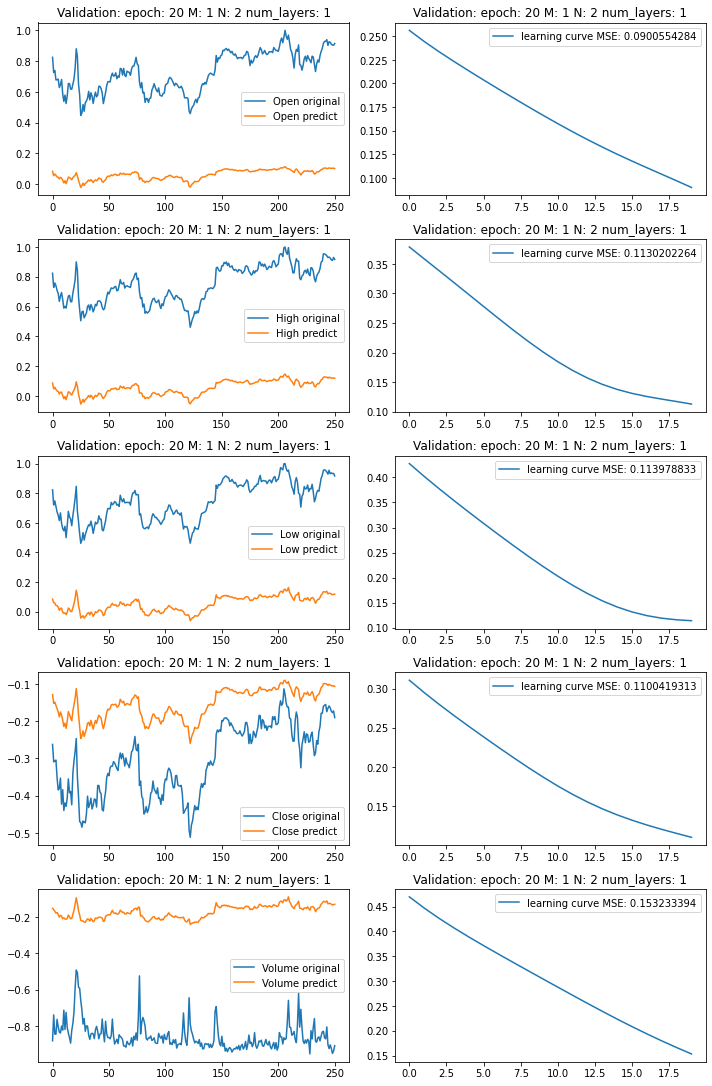

In [10]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 20
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  30 MSE:  0.05017019435763359
Training time: 0.08190608024597168
Epoch  30 MSE:  0.06136195361614227
Training time: 0.07698416709899902
Epoch  30 MSE:  0.03874881565570831
Training time: 0.07532095909118652
Epoch  30 MSE:  0.04386148229241371
Training time: 0.07329201698303223
Epoch  30 MSE:  0.044753510504961014
Training time: 0.07293987274169922
------------Validation plots----------


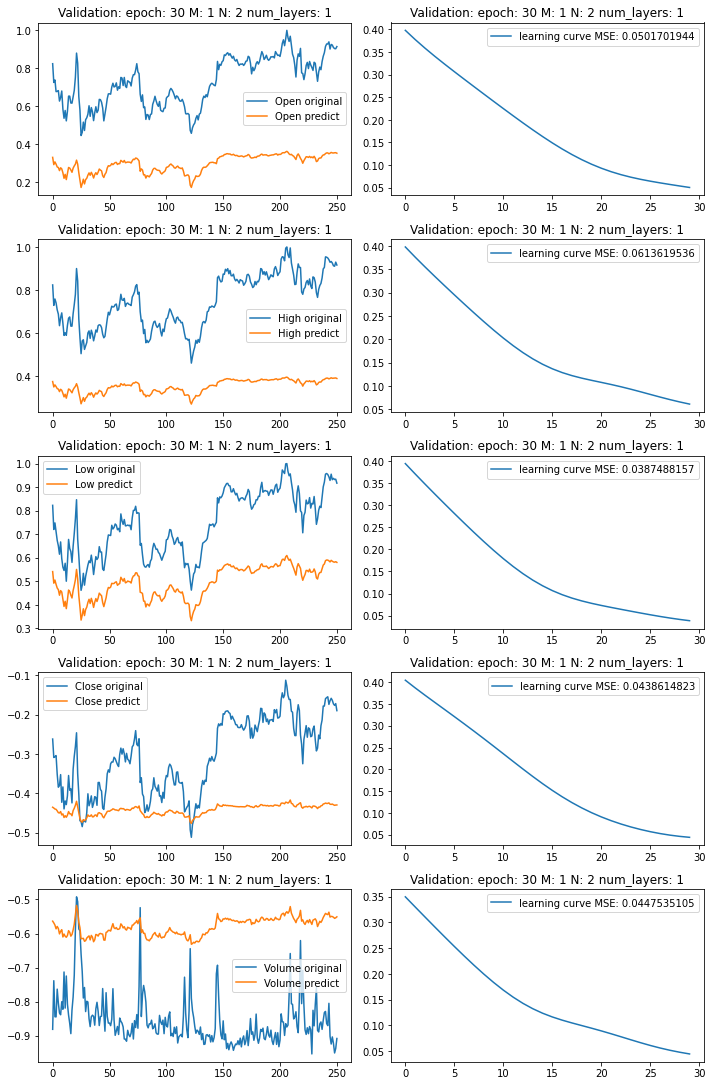

In [11]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 30
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)




<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  50 MSE:  0.010757796466350555
Training time: 0.11947274208068848
Epoch  50 MSE:  0.020096691325306892
Training time: 0.12255001068115234
Epoch  50 MSE:  0.038044072687625885
Training time: 0.12052798271179199
Epoch  50 MSE:  0.028969522565603256
Training time: 0.12416505813598633
Epoch  50 MSE:  0.009199514985084534
Training time: 0.12079381942749023
------------Validation plots----------


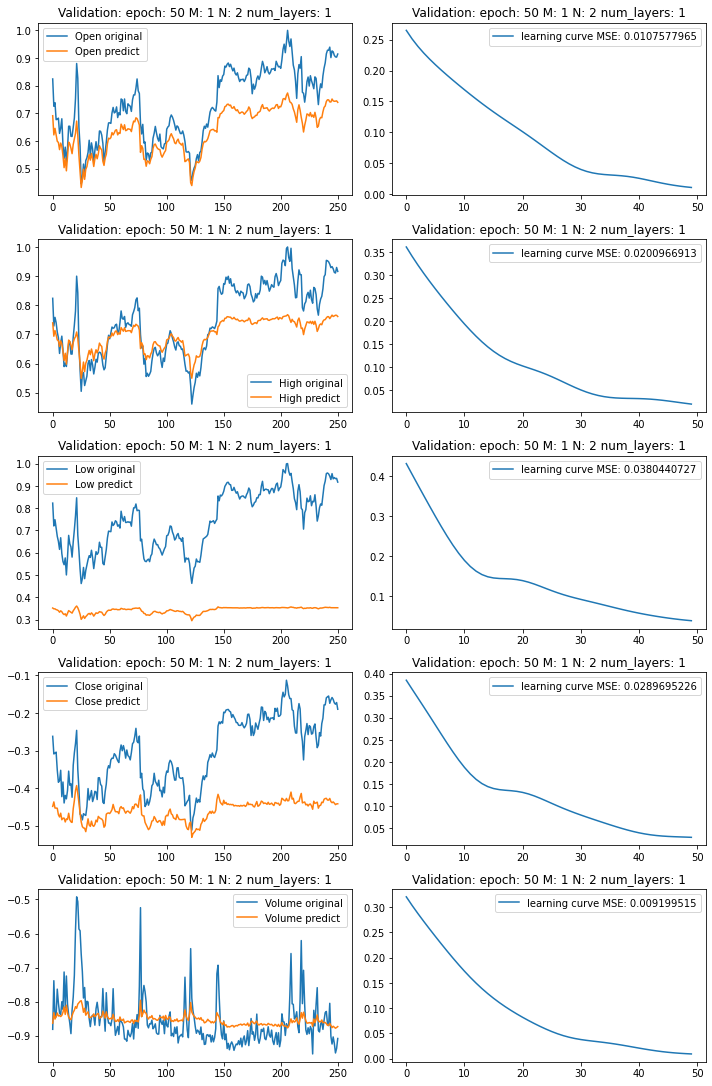

In [12]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 50
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  100 MSE:  0.003639035625383258
Training time: 0.36289000511169434
Epoch  100 MSE:  0.0033378859516233206
Training time: 0.24916362762451172
Epoch  100 MSE:  0.0040724859572947025
Training time: 0.2428908348083496
Epoch  100 MSE:  0.0030214174184948206
Training time: 0.26409029960632324
Epoch  100 MSE:  0.004619484301656485
Training time: 0.24724602699279785
------------Validation plots----------


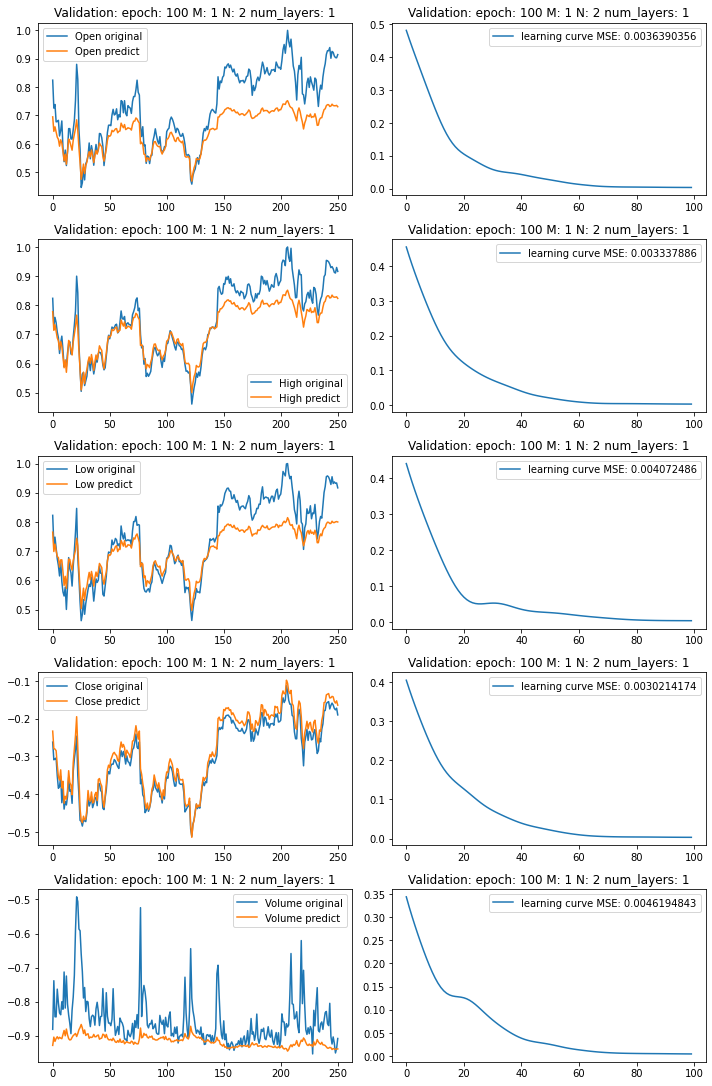

In [13]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 100
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)



<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  200 MSE:  0.001959563698619604
Training time: 0.7209608554840088
Epoch  200 MSE:  0.001084169140085578
Training time: 0.7262718677520752
Epoch  200 MSE:  0.0017100325785577297
Training time: 0.7532870769500732
Epoch  200 MSE:  0.0010542792733758688
Training time: 0.7279529571533203
Epoch  200 MSE:  0.0007008734974078834
Training time: 0.6611030101776123
------------Validation plots----------


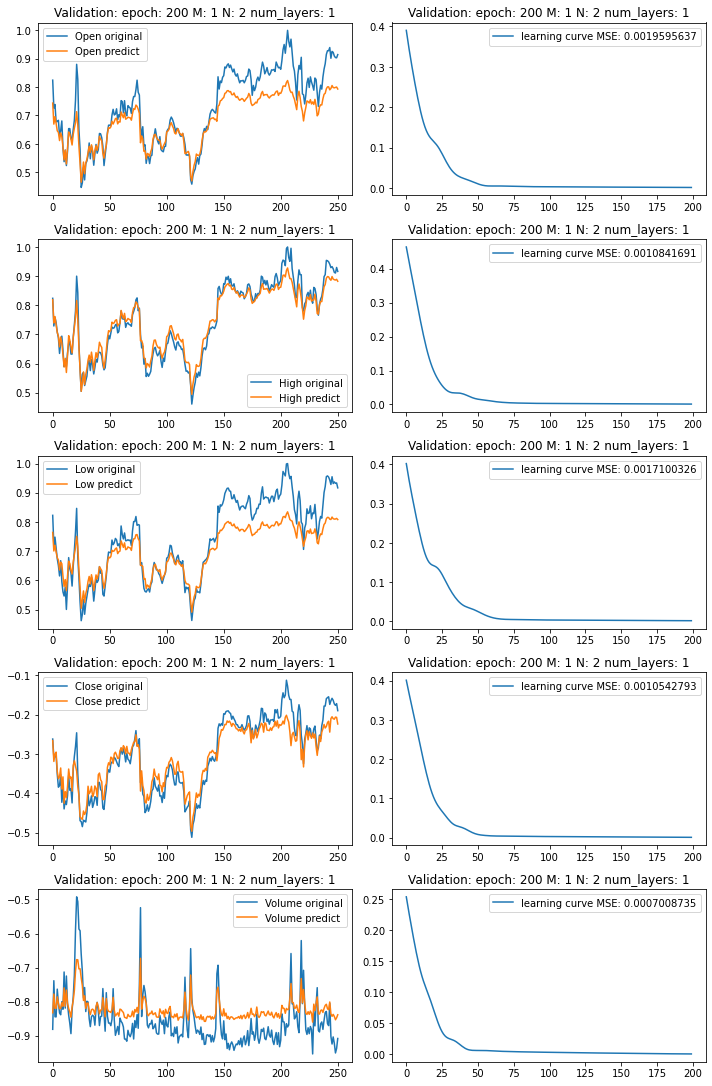

In [14]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 200
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  500 MSE:  0.0002461870026309043
Training time: 1.3068900108337402
Epoch  500 MSE:  0.0002573361562099308
Training time: 1.3455488681793213
Epoch  500 MSE:  0.00028353306697681546
Training time: 1.233029842376709
Epoch  500 MSE:  0.0002814193139784038
Training time: 1.2832717895507812
Epoch  500 MSE:  0.00045429173042066395
Training time: 1.3323369026184082
------------Validation plots----------


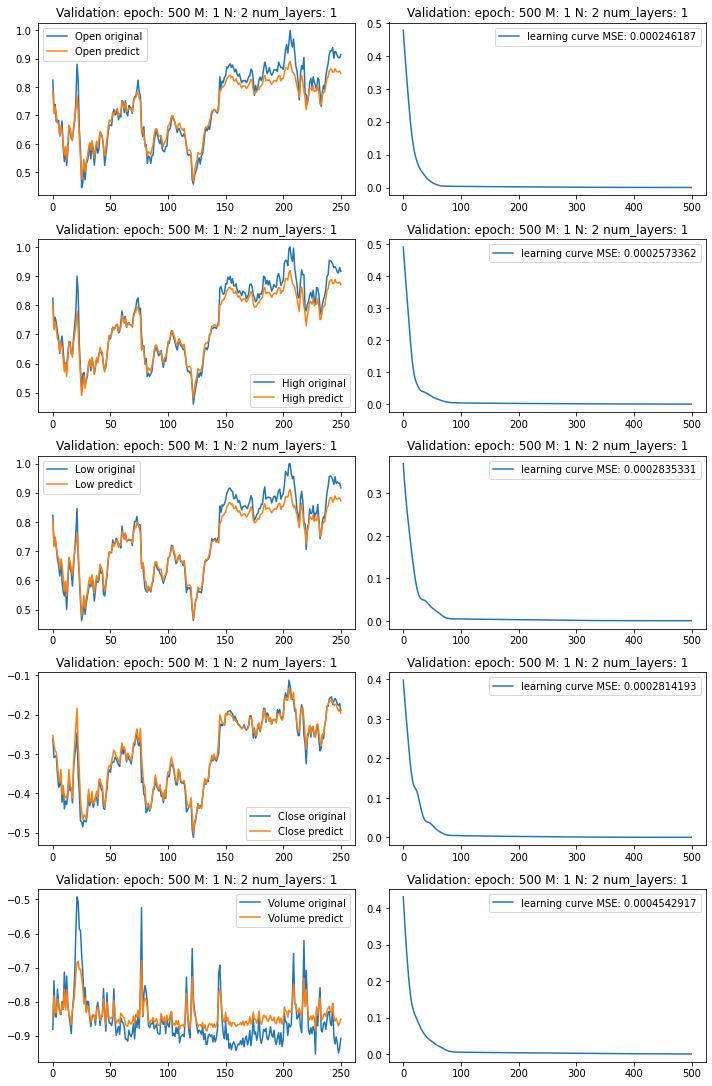

In [15]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 500
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  1000 MSE:  9.099595627048984e-05
Training time: 3.3983349800109863
Epoch  1000 MSE:  6.897643470438197e-05
Training time: 3.667879104614258
Epoch  1000 MSE:  7.755864498903975e-05
Training time: 2.839750051498413
Epoch  1000 MSE:  7.201163680292666e-05
Training time: 2.571068286895752
Epoch  1000 MSE:  9.456050611333922e-05
Training time: 2.632138967514038
------------Validation plots----------


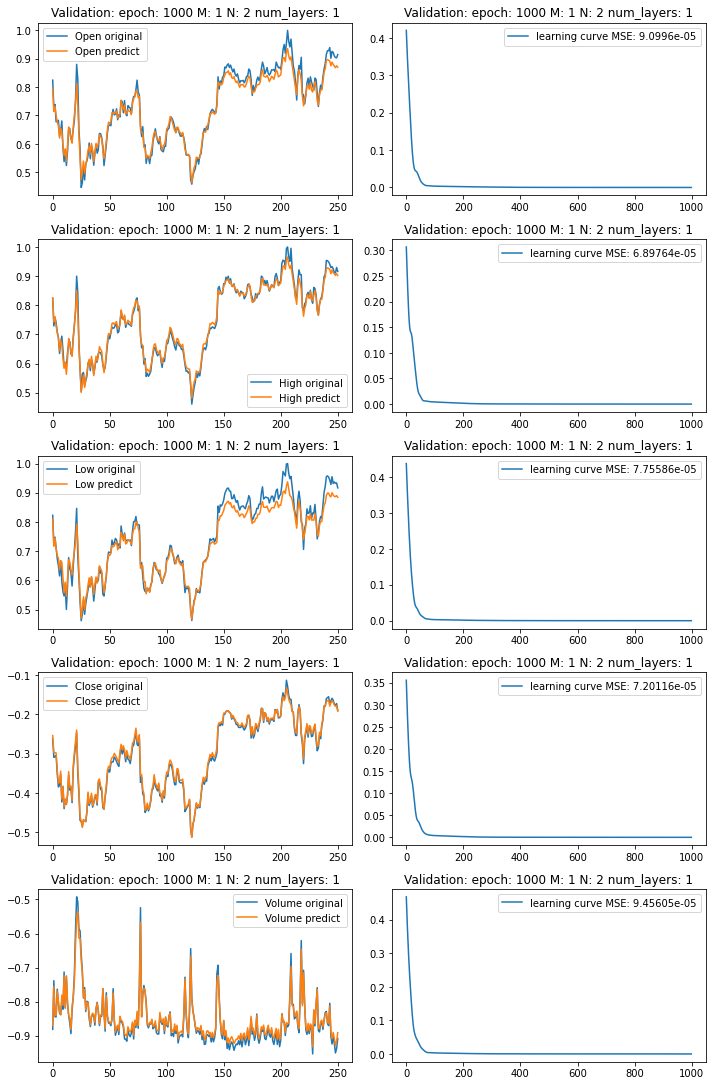

In [16]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 1000
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

<ipython-input-7-b59919a3d6bf>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train).float()
<ipython-input-7-b59919a3d6bf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_vali = torch.tensor(x_vali).float()
<ipython-input-7-b59919a3d6bf>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_lstm = torch.tensor(y_train_lstm).float()
<ipython-input-7-b59919a3d6bf>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires

Epoch  3000 MSE:  3.665338590508327e-05
Training time: 7.6835222244262695
Epoch  3000 MSE:  3.8488324207719415e-05
Training time: 7.907145977020264
Epoch  3000 MSE:  3.5467499401420355e-05
Training time: 7.700954914093018
Epoch  3000 MSE:  3.160601409035735e-05
Training time: 7.944028854370117
Epoch  3000 MSE:  2.5729063054313883e-05
Training time: 9.712640047073364
------------Validation plots----------


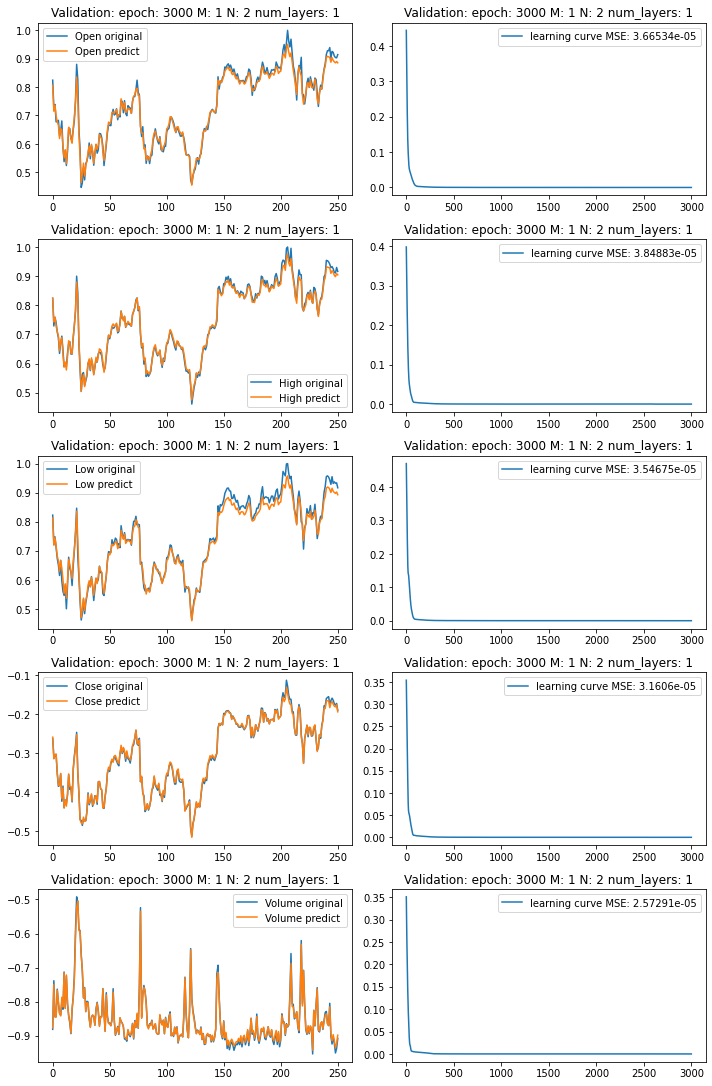

In [17]:
N = 2
M = 1

num_layers = 1
use_all_data = True
epochs_list = 3000
y_vali_lstm_plot_list, pred_vali_plot_list, loss_rate_list = hyper_tune(pf_test, N, M, num_layers, use_all_data, epochs_list)

# Testing